In [1]:
import spacy
import pickle
import random
import json
from spacy.tokens import DocBin
from tqdm import tqdm
import json

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
json_file_path = '/kaggle/input/ner-resume-input-final/dataset.json'
with open(json_file_path, "r" , encoding = "utf-8") as f:
    cv_data = json.load(f)

In [4]:
num_docs = len(cv_data)
print(f"Total documents: {num_docs}")

Total documents: 1014


**DATA UNDERSTANDING**

In [5]:
cv_data[0]

['\xa0 \xa0\nContact\nwww.linkedin.com/in/omjagri\n(LinkedIn)\nTop Skills\nphp\nMySQL\nJavaScript\nCertifications\nPhp & Js Om Prakash Jagri\nFull Stack Developer | PHP | Laravel | Vue Js\nKathmandu, Bāgmatī, Nepal\nSummary\nExperienced Developer with a demonstrated history of working in\nthe information technology and services industry. Skilled in Laravel,\nPHP, Cascading Style Sheets (CSS), JavaScript, vue js and MySQL.\nStrong engineering professional with a B.sc.CSIT(Bachelors of\nScience in Computer Science and Information Technology) focused\nin Computer Science from Tribhuvan University, Institute of Science\n& Tchnology. \nExperience\nSearchable Design LLC\nSoftware Developer\nJune 2021\xa0-\xa0Present\xa0 (1 year 7 months)\nNepal\nFull Stack Developer Laravel with Vue Js\nBenekiva\nTechnical Documentation\nSeptember 2021\xa0-\xa0Present\xa0 (1 year 4 months)\nUnited States\nBidhee\n3 years 9 months\nLaravel Developer\nMarch 2018\xa0-\xa0May 2021\xa0 (3 years 3 months)\nBaneswa

In [6]:
# Get inforamtion about the dataset 
def compute_metrics(documents):
    text_lengths = []        
    annotations_count = []  
    annotation_labels = []

    for doc in documents:
        if not isinstance(doc, list) or len(doc) != 2:
            print(f"Skipping document with unexpected structure: {doc}")
            continue

        text, ann_dict = doc[0], doc[1]
        text_lengths.append(len(text))
        entities = ann_dict.get("entities", [])
        annotations_count.append(len(entities))
        
        for entity in entities:
            if len(entity) >= 3:
                annotation_labels.append(entity[2])
            else:
                print(f"Unexpected entity format: {entity}")

    num_docs = len(text_lengths)
    total_annotations = sum(annotations_count)
    avg_text_length = sum(text_lengths) / num_docs if num_docs > 0 else 0
    avg_annotations_per_doc = total_annotations / num_docs if num_docs > 0 else 0

    metrics = {
        "total_documents": num_docs,
        "total_annotations": total_annotations,
        "avg_text_length": avg_text_length,
        "avg_annotations_per_doc": avg_annotations_per_doc,
        "annotation_labels": annotation_labels
    }
    
    return metrics

In [7]:
def print_metrics(metrics):
    print("========== Basic Dataset Statistics ==========")
    print(f"Total documents: {metrics.get('total_documents', 0)}")
    print(f"Total annotations: {metrics.get('total_annotations', 0)}")
    print(f"Average text length: {metrics.get('avg_text_length', 0):.2f} characters")
    print(f"Average annotations per document: {metrics.get('avg_annotations_per_doc', 0):.2f}")

In [8]:
dataset1_infor = compute_metrics(cv_data)
print_metrics(dataset1_infor)

========== Basic Dataset Statistics ==========
Total documents: 1014
Total annotations: 24253
Average text length: 2082.54 characters
Average annotations per document: 23.92


In [9]:
label_counter_1 = Counter(dataset1_infor['annotation_labels'])
print("\n---------- Distinct Annotation Labels ----------")
for label, count in label_counter_1.items():
    print(f"{label}: {count}")


---------- Distinct Annotation Labels ----------
LINKEDIN LINK: 1038
SKILLS: 4349
CERTIFICATION: 1670
NAME: 1013
LOCATION: 935
COMPANIES WORKED AT: 3567
WORKED AS: 4092
YEARS OF EXPERIENCE: 3765
COLLEGE NAME: 522
DEGREE: 1235
UNIVERSITY: 756
YEAR OF GRADUATION: 232
EMAIL ADDRESS: 30
LANGUAGE: 803
AWARDS: 242
DESIGNATION: 1
Unlabelled: 2
CONTACT: 1


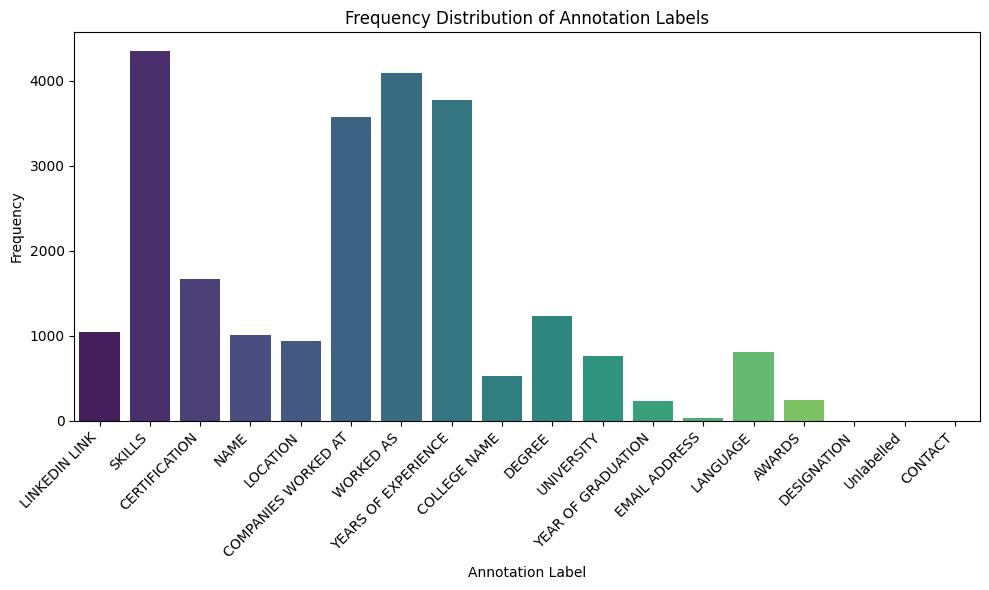

In [10]:
import pandas as pd
data = pd.DataFrame({
    "Annotation Label": list(label_counter_1.keys()),
    "Frequency": list(label_counter_1.values())
})

plt.figure(figsize=(10, 6))
sns.barplot(data=data, x="Annotation Label", y="Frequency", palette="viridis")
plt.xlabel("Annotation Label")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Annotation Labels")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

REMOVE LOW FREQUENCY LABELS

In [11]:
VALID_LABELS = {
    "LINKEDIN LINK",
    "SKILLS",
    "CERTIFICATION",
    "NAME",
    "LOCATION",
    "COMPANIES WORKED AT",
    "WORKED AS",
    "YEARS OF EXPERIENCE",
    "COLLEGE NAME",
    "DEGREE",
    "UNIVERSITY",
    "YEAR OF GRADUATION",
    "LANGUAGE",
    "AWARDS",
    "DESIGNATION"
}

def remove_invalid_labels(dataset):
    cleaned = []
    for text, ann in dataset:
        # print('TEXT: ',text[:10],'ANN: ',ann)
        valid_entities = [
            [start, end, label]
            for start, end, label in ann.get("entities", [])
            if label in VALID_LABELS and start < end
        ]
        
        if valid_entities:
            cleaned.append([text, {"entities": valid_entities}])
    return cleaned

In [12]:
new_data = remove_invalid_labels(cv_data)

In [13]:
def get_spacy_doc(error_log_file, data):
    nlp = spacy.load("en_core_web_sm")
    db = DocBin()

    for item in tqdm(data, desc="Processing documents"):
        try:
            text, annotation_dict = item
            
            # Ensure text is properly encoded/decoded.
            text = text.encode("utf-8", errors="replace").decode("utf-8")
            doc = nlp.make_doc(text)
            ents = []
            entity_indices = set()
            
            annotations = annotation_dict.get("entities", [])
            for annotation in annotations:
                if len(annotation) < 3:
                    error_log_file.write(f"Skipping malformed annotation: {annotation}\n")
                    continue

                start, end, label = annotation
                label = label.upper()
                
                # Skip this entity if any index in the span is already used.
                if any(idx in entity_indices for idx in range(start, end)):
                    continue
                entity_indices.update(range(start, end))

                span = doc.char_span(start, end, label=label, alignment_mode="strict")
                if span is None:
                    error_log_file.write(
                        f"Skipping entity: {label} [{start}-{end}] in text:\n{text[:100]}...\n"
                    )
                    continue
                ents.append(span)
            doc.ents = ents
            db.add(doc)
        except Exception as e:
            error_log_file.write(f"Error processing document starting with '{text[:50]}...': {e}\n")
            continue

    return db

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(new_data, test_size=0.3)

In [15]:
len(train), len(test)

(709, 305)

In [16]:
file = open("error_data.txt", "w")
db = get_spacy_doc(file, train)
db.to_disk("train_data.spacy")

db = get_spacy_doc(file, test)
db.to_disk("test_data.spacy")

file.close()

Processing documents: 100%|██████████| 305/305 [00:02<00:00, 132.60it/s]
